In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score , precision_score, recall_score

In [2]:
#check the gpu is available for training
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
dataset_dir = "E:/Nigga/tomatodiseasedetection/tomato_dataset"

In [4]:
image_size = 224
batch_size = 32
channel = 3
n_classes = 10

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

Found 16011 files belonging to 10 classes.


In [6]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

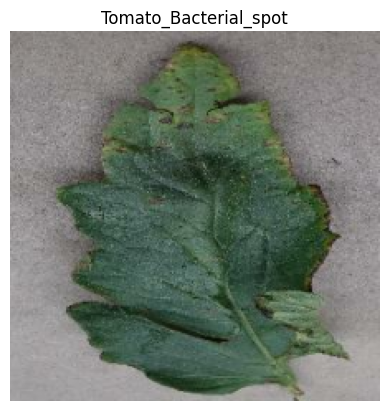

In [7]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [8]:
def split_dataset(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True, shuffle_size=10000):
    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=123)
    train_size = int(train_split*dataset_size)
    val_size = int(val_split*dataset_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)
    return train_dataset, val_dataset, test_dataset

In [9]:
train_dataset , val_dataset , test_dataset = split_dataset(dataset=dataset)

In [10]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
len(train_dataset)

400

In [12]:
len(test_dataset)

51

In [13]:
len(val_dataset)

50

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2)
])

In [15]:
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size, image_size, channel)
)

In [17]:
base_model.trainable = False

In [18]:
model = models.Sequential(
    [
        layers.Rescaling(1.0 / 255),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation="softmax"),
    ]
)

In [19]:
model.build(input_shape=(None,image_size,image_size,channel))

In [20]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                      

In [21]:
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
)
early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [22]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[lr_reducer, early_stopper]
)

Epoch 1/50
400/400 [==============================] - 121s 267ms/step - loss: 2.2753 - accuracy: 0.1703 - val_loss: 2.1546 - val_accuracy: 0.2169 - lr: 1.0000e-04
Epoch 2/50
400/400 [==============================] - 98s 244ms/step - loss: 2.1844 - accuracy: 0.2003 - val_loss: 2.0877 - val_accuracy: 0.2387 - lr: 1.0000e-04
Epoch 3/50
400/400 [==============================] - 96s 239ms/step - loss: 2.1418 - accuracy: 0.2175 - val_loss: 2.0262 - val_accuracy: 0.2444 - lr: 1.0000e-04
Epoch 4/50
400/400 [==============================] - 97s 241ms/step - loss: 2.1108 - accuracy: 0.2248 - val_loss: 2.0223 - val_accuracy: 0.2319 - lr: 1.0000e-04
Epoch 5/50
400/400 [==============================] - 95s 238ms/step - loss: 2.0950 - accuracy: 0.2302 - val_loss: 2.0306 - val_accuracy: 0.2387 - lr: 1.0000e-04
Epoch 6/50
400/400 [==============================] - 96s 239ms/step - loss: 2.0818 - accuracy: 0.2359 - val_loss: 1.9721 - val_accuracy: 0.2875 - lr: 1.0000e-04
Epoch 7/50
400/400 [=======

In [23]:
scores = model.evaluate(test_dataset)
print("Test Accuracy:", scores[1])

51/51 [==============================] - 11s 66ms/step - loss: 1.9956 - accuracy: 0.2911
Test Accuracy: 0.2910539209842682


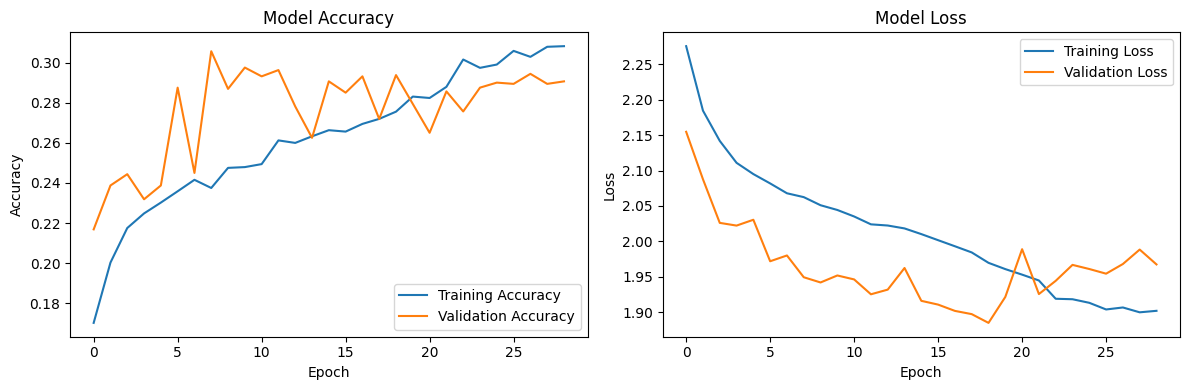

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
def predict(model, image):
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


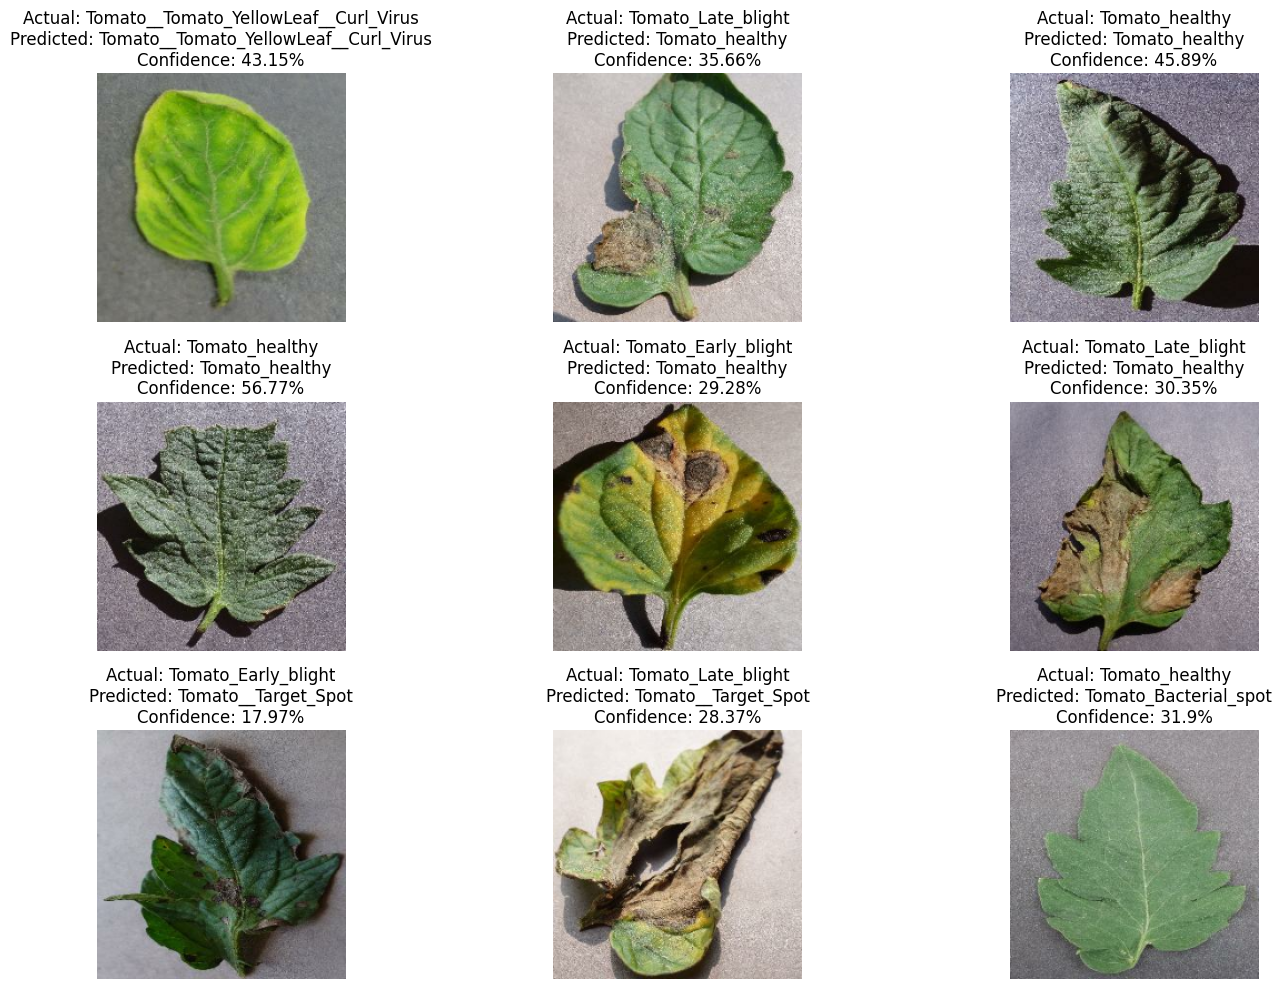

In [26]:
plt.figure(figsize=(15, 10))
for images, labels in test_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")
plt.tight_layout()

1/1 [==============================] - 0s 31ms/step


<Figure size 1000x800 with 0 Axes>

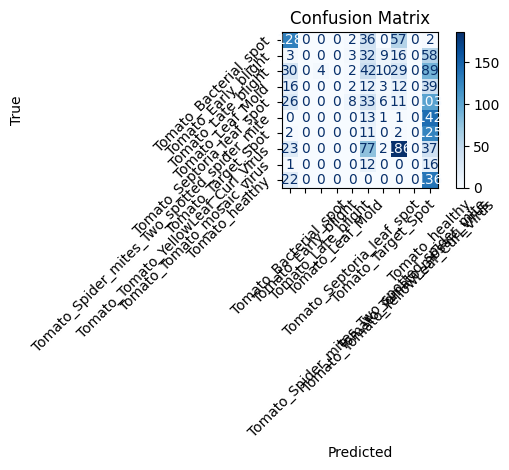

In [27]:
y_true = []
y_pred = []
for x, y in test_dataset:
    y_pred.extend(np.argmax(model.predict(x), axis=1))
    y_true.extend(y)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

display_labels = [
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato_Target_Spot',
    'Tomato_Tomato_YellowLeaf_Curl_Virus',
    'Tomato_Tomato_mosaic_virus',
    'Tomato_healthy'
]

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [28]:
f1_scores = f1_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

print("F1 Scores:")
print("Tomato_Bacterial_spot:", f1_scores[0])
print("Tomato_Early_blight:", f1_scores[1])
print("Tomato_Late_blight:", f1_scores[2])
print("Tomato_Leaf_Mold:", f1_scores[3])
print("Tomato_Septoria_leaf_spot:", f1_scores[4])
print("Tomato_Spider_mites_Two_spotted_spider_mite:", f1_scores[5])
print("Tomato_Target_Spot:", f1_scores[6])
print("Tomato_Tomato_YellowLeaf_Curl_Virus:", f1_scores[7])
print("Tomato_Tomato_mosaic_virus:", f1_scores[8])
print("Tomato_healthy:", f1_scores[9])

macro_f1 = f1_score(y_true, y_pred, average='macro')
print("Macro-averaged F1 Score:", macro_f1)

F1 Scores:
Tomato_Bacterial_spot: 0.5378151260504201
Tomato_Early_blight: 0.0
Tomato_Late_blight: 0.03809523809523809
Tomato_Leaf_Mold: 0.0
Tomato_Septoria_leaf_spot: 0.0784313725490196
Tomato_Spider_mites_Two_spotted_spider_mite: 0.06117647058823529
Tomato_Target_Spot: 0.0
Tomato_Tomato_YellowLeaf_Curl_Virus: 0.5821596244131455
Tomato_Tomato_mosaic_virus: 0.0
Tomato_healthy: 0.3005524861878453
Macro-averaged F1 Score: 0.15982303178839039


In [29]:
precision = precision_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
recall = recall_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

print("Precision:")
print("Tomato_Bacterial_spot:", precision[0])
print("Tomato_Early_blight:", precision[1])
print("Tomato_Late_blight:", precision[2])
print("Tomato_Leaf_Mold:", precision[3])
print("Tomato_Septoria_leaf_spot:", precision[4])
print("Tomato_Spider_mites_Two_spotted_spider_mite:", precision[5])
print("Tomato_Target_Spot:", precision[6])
print("Tomato_Tomato_YellowLeaf_Curl_Virus:", precision[7])
print("Tomato_Tomato_mosaic_virus:", precision[8])
print("Tomato_healthy:", precision[9])

print("\nRecall:")
print("Tomato_Bacterial_spot:", recall[0])
print("Tomato_Early_blight:", recall[1])
print("Tomato_Late_blight:", recall[2])
print("Tomato_Leaf_Mold:", recall[3])
print("Tomato_Septoria_leaf_spot:", recall[4])
print("Tomato_Spider_mites_Two_spotted_spider_mite:", recall[5])
print("Tomato_Target_Spot:", recall[6])
print("Tomato_Tomato_YellowLeaf_Curl_Virus:", recall[7])
print("Tomato_Tomato_mosaic_virus:", recall[8])
print("Tomato_healthy:", recall[9])


Precision:
Tomato_Bacterial_spot: 0.5099601593625498
Tomato_Early_blight: 0.0
Tomato_Late_blight: 1.0
Tomato_Leaf_Mold: 0.0
Tomato_Septoria_leaf_spot: 0.47058823529411764
Tomato_Spider_mites_Two_spotted_spider_mite: 0.048507462686567165
Tomato_Target_Spot: 0.0
Tomato_Tomato_YellowLeaf_Curl_Virus: 0.5923566878980892
Tomato_Tomato_mosaic_virus: 0.0
Tomato_healthy: 0.18206157965194109

Recall:
Tomato_Bacterial_spot: 0.5688888888888889
Tomato_Early_blight: 0.0
Tomato_Late_blight: 0.019417475728155338
Tomato_Leaf_Mold: 0.0
Tomato_Septoria_leaf_spot: 0.0427807486631016
Tomato_Spider_mites_Two_spotted_spider_mite: 0.08280254777070063
Tomato_Target_Spot: 0.0
Tomato_Tomato_YellowLeaf_Curl_Virus: 0.5723076923076923
Tomato_Tomato_mosaic_virus: 0.0
Tomato_healthy: 0.8607594936708861


c:\Users\user\anaconda3\envs\nigga_use_gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
model.save('tomatodisease_resnet50.h5')

In [31]:
model.save('tomatodisease_resnet50.keras')